In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio
import scipy.signal
import scipy.interpolate
from scipy.interpolate import interp1d
import pylops
import seaborn as sns
import cmocean as cm
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [2]:
print('Numpy', np.__version__)
print('Scipy', scipy.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('Pylops', pylops.__version__)

Numpy 1.22.0
Scipy 1.8.0
Pandas 2.0.3
Matplotlib 3.7.2
Pylops 2.1.0


In [3]:
#Loading seismic using Segyio lib

#------------------------------------------------------------------------------------------
# string containing the path location of the seismic data at disk
segy_file_path = "Iara_Time_ATP_CUT_NEW_3D.sgy" # <----------------------- Preencher com o caminho para o arquivo
#------------------------------------------------------------------------------------------

#loading stack using Segyio lib
stack = segyio.open(segy_file_path,iline=185,
                xline=181)
#Allocating IL, XL, Time axis in variables
il, xl, t = stack.ilines, stack.xlines, stack.samples
#Measuring Sample rate from data samples
dt = t[1] - t[0]
#Creating seismic cube format using segyio cube method
data_cube = segyio.cube(stack)
#Qc of the axis shapes
nil, nxl, nt = data_cube.shape

# Inlines information
il_start, il_end = il[0], il[-1]

# Crosslines information
xl_start, xl_end = xl[0], xl[-1]

In [4]:
print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', nil, nxl, nt)
print('Inline start:', il_start, '    ', 'Inline end:', il_end,'Inline increment:', il[1] - il[0])
print('Crossline start:', xl_start, '    ', 'Crossline end:', xl_end,'Crossline increment:', xl[1] - xl[0])
print('Sample rate [ms]:', dt)
print('Number of samples by trace:', stack.tracecount)
print('Two-way-time array:', t)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  512 668 2000
Inline start: 7554      Inline end: 8065 Inline increment: 1
Crossline start: 6313      Crossline end: 6980 Crossline increment: 1
Sample rate [ms]: 4.0
Number of samples by trace: 342016
Two-way-time array: [0.000e+00 4.000e+00 8.000e+00 ... 7.988e+03 7.992e+03 7.996e+03]


In [5]:
#Carregar o modelo de baixas
filename = "background_all_wells_shift_base_sal-200_CUT_NEW_3D.sgy" #<-------------------- Preencher com o caminho para o arquivo do modelo de baixas

In [6]:
segy_file_path = filename

#loading stack using Segyio lib
m0 = segyio.open(segy_file_path,iline=185,
                xline=181)
#Allocating IL, XL, Time axis in variables
m0_il, m0_xl, m0_t = m0.ilines, m0.xlines, m0.samples
#Measuring Sample rate from data samples
m0_dt = m0_t[1] - m0_t[0]
#Creating seismic cube format using segyio cube method
m0_cube = segyio.cube(m0)
#Qc of the axis shapes
m0_nil, m0_nxl, m0_nt = m0_cube.shape

# Inlines information
m0_il_start, m0_il_end = m0_il[0], m0_il[-1]

# Crosslines information
m0_xl_start, m0_xl_end = m0_xl[0], m0_xl[-1]

In [7]:
print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', nil, nxl, m0_nt)
print('Inline start:', il_start, '    ', 'Inline end:', il_end,'Inline increment:', il[1] - il[0])
print('Crossline start:', xl_start, '    ', 'Crossline end:', xl_end,'Crossline increment:', xl[1] - xl[0])
print('Sample rate [ms]:', dt)
print('Number of samples by trace:', m0.tracecount)
print('Two-way-time array:', t)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  512 668 2000
Inline start: 7554      Inline end: 8065 Inline increment: 1
Crossline start: 6313      Crossline end: 6980 Crossline increment: 1
Sample rate [ms]: 4.0
Number of samples by trace: 342016
Two-way-time array: [0.000e+00 4.000e+00 8.000e+00 ... 7.988e+03 7.992e+03 7.996e+03]


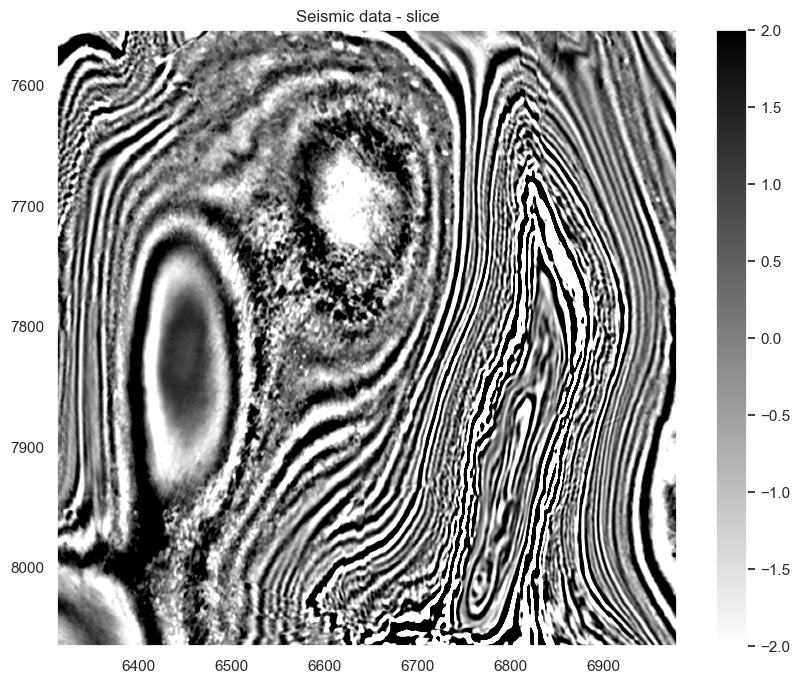

In [8]:
plt.figure(figsize=(10, 8))
plt.imshow(data_cube[..., 900], cmap='gray_r', vmin=-2, vmax=2,
           extent=(xl_start, xl_end, il_end, il_start))
plt.title('Seismic data - slice')
plt.colorbar()
plt.grid(False)
plt.axis('tight');

In [9]:
topo = pd.read_csv("Horizontes_tempo\\teste@Base_Sal@0509_presal@wagner.txt",
                 sep='\s+', usecols=(2, 5, 8), names=['Y', 'X', 'Z'])
base = pd.read_csv("Horizontes_tempo\\teste@Buracica_Jiquia_ATP@0509_presal@wagner.txt",
                 sep='\s+', usecols=(2, 5, 8), names=['Y', 'X', 'Z'])
topo_shift  = topo - 180
#itapema = pd.read_csv("Fm_Itapema@@wagner.txt",
#                 sep='\s+', usecols=(2, 5, 8), names=['Y', 'X', 'Z'])

In [10]:
topo.head()

Y     X           Z
0  8737  6023  5138.11279
1  8737  6024  5137.55176
2  8737  6025  5137.02393
3  8737  6026  5136.53076
4  8737  6027  5136.22461

In [11]:
base.head()

Y     X           Z
0  7708  8470  5097.29688
1  7709  8470  5097.98340
2  7710  8470  5098.71045
3  7711  8470  5099.39697
4  7712  8470  5100.03320

(5300.0, 4700.0)

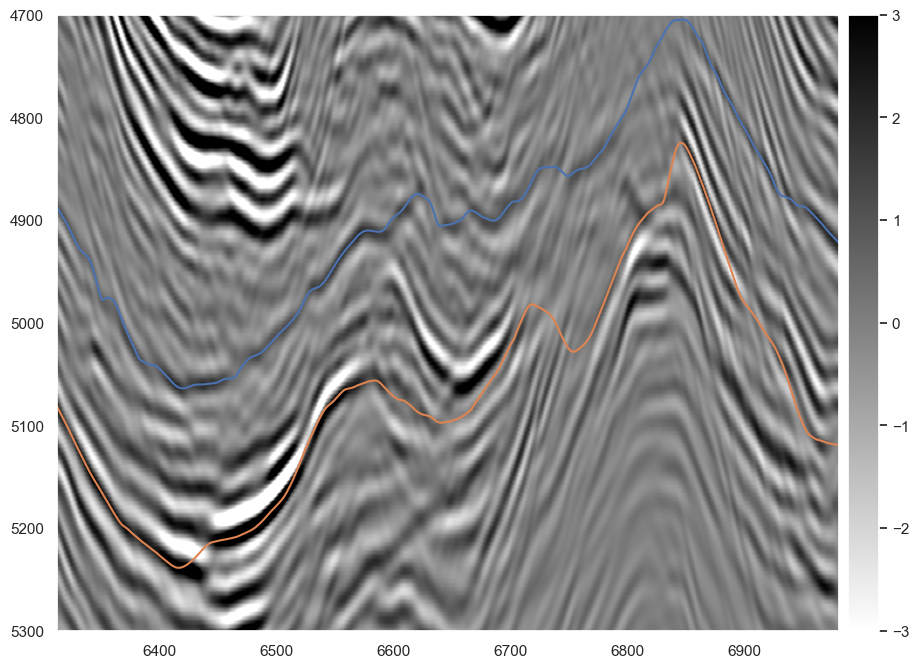

In [12]:
#plotting data
fig, ax = plt.subplots(figsize=(12, 8))
c=ax.imshow(data_cube[7857-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-3, vmax=3,
            extent=[xl_start, xl_end, t[-1], t[0]])
ax.plot(topo.loc[topo.Y==7857].X, topo.loc[topo.Y==7857].Z)
ax.plot(base.loc[base.Y==7857].X, base.loc[base.Y==7857].Z)
#ax.plot(itapema.loc[itapema.Y==7805].X, itapema.loc[itapema.Y==7805].Z)


plt.colorbar(c, ax=ax, pad=0.01)
ax.set_xlim(xl_start, xl_end)
plt.grid(False)
ax.set_ylim(5300, 4700)

In [13]:
topo_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
base_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
itapema_surface = np.full((nil, nxl), np.nan, dtype=np.float32)

ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 

for idx, inline in enumerate(ils):
    x = topo.loc[topo.Y == inline].X
    y = topo.loc[topo.Y == inline].Z
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    topo_surface[idx, :] = interp(xls)
    print(f'Inline {inline}/{ils[-1]}\r', end="")   
#topo_surface = topo_surface.T

for idx, inline in enumerate(ils):
    x = base.loc[base.Y == inline].X
    y = base.loc[base.Y == inline].Z
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    base_surface[idx, :] = interp(xls)
    print(f'Inline {inline}/{ils[-1]}\r', end="")    
#base_surface = base_surface.T


In [14]:

m0_cube_low = scipy.ndimage.gaussian_filter(m0_cube[:, :, :], sigma=(10,10,10))

(5500.0, 4300.0)

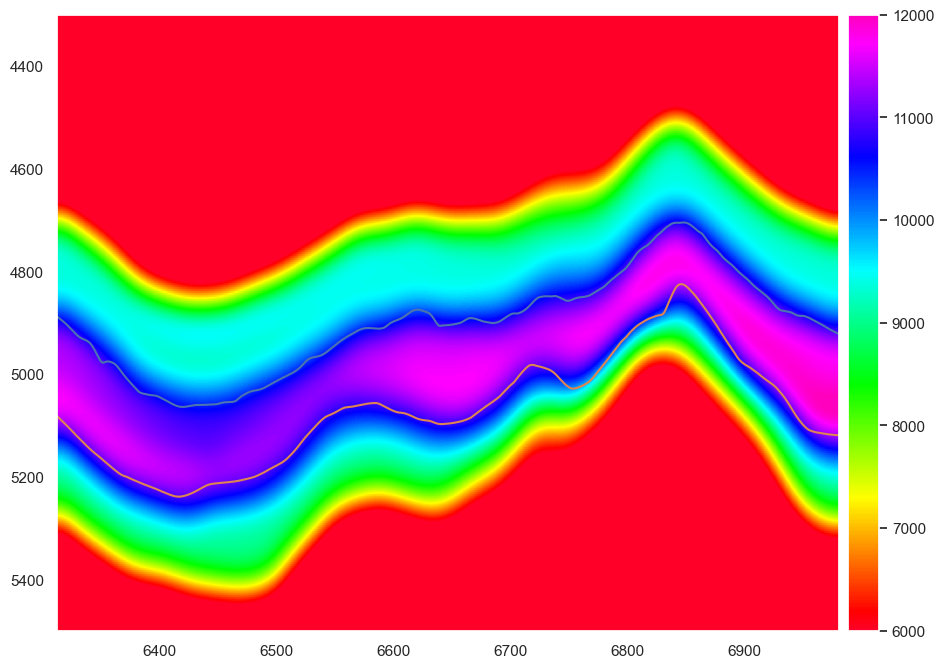

In [15]:
#plotting data
fig, ax = plt.subplots(figsize=(12, 8))
c=ax.imshow(m0_cube_low[7857-il_start, :, :].T, aspect='auto', cmap='gist_rainbow', vmin=6000, vmax=12000,#<-------------------- Mudar 6600 para outro valor para mudar de Inline entre 6313-6980
            extent=[xl_start, xl_end, t[-1], t[0]])
ax.plot(topo.loc[topo.Y==7857].X, topo.loc[topo.Y==7857].Z) 
ax.plot(base.loc[base.Y==7857].X, base.loc[base.Y==7857].Z)
plt.colorbar(c, ax=ax, pad=0.01)
ax.set_xlim(xl_start, xl_end)
plt.grid(False)
ax.set_ylim(5500, 4300)

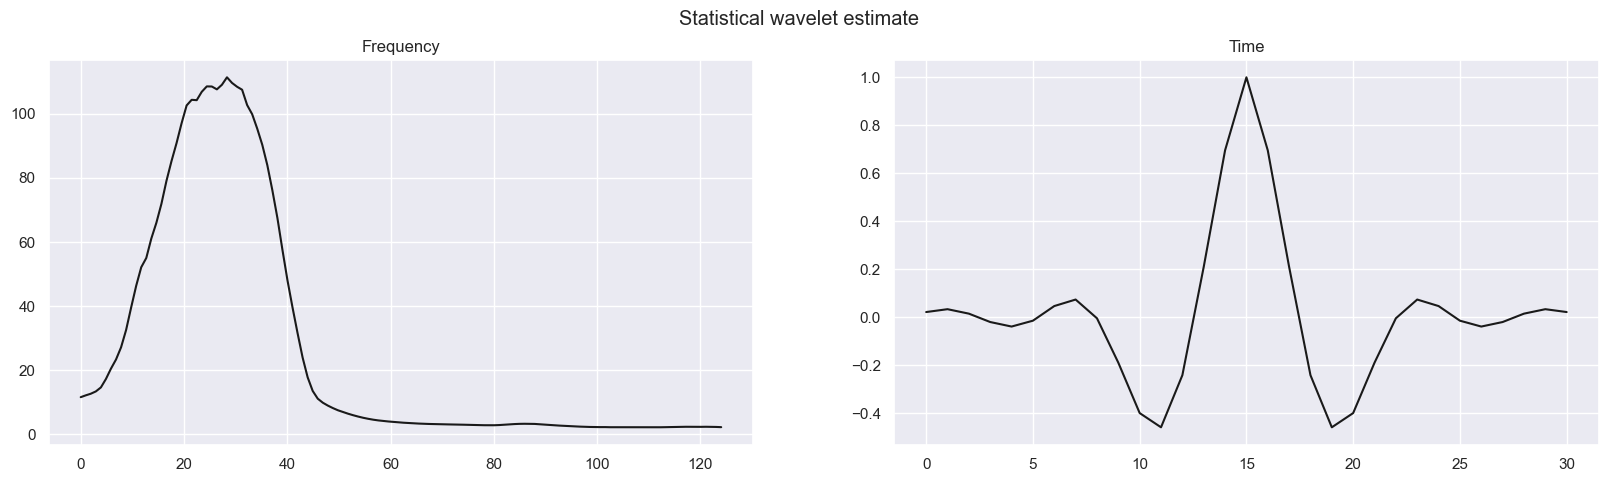

In [16]:
#Another wavelet estimation method (Statistical)

nt_wav = 16 # lenght of wavelet in samples (The resulting number of samples would be nt_wav*2 +1)
nfft = 2**8 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(data_cube[..., 750:1200], nfft, axis=-1)), axis=(0, 1)) #<------------------------------------ from 3000ms to 4700ms window; index interval--->{750...1200} se quiser mudar os valores da janela so modificar o valor dos indices lembrando que tempo = index*4ms
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(wav_est, 'k')
axs[1].set_title('Time');

In [17]:
len(wav_est)

31

In [80]:
# Inverting at Inline 6600

# Seismic amplitude section
amp = data_cube[7857 - il_start, :, 750:1500].T
print("Shape of data [n_samples, n_traces]:", amp.shape)
# Log of the low frequency model of impedance
mback = np.log(m0_cube[7857 - il_start, :, 750:1500].T)
mback_2 = np.log(m0_cube_low[7857 - il_start, :, 750:1500].T)
# Wavelet operator
nz, nx = amp.shape

Shape of data [n_samples, n_traces]: (750, 668)


In [81]:
PPop = pylops.avo.poststack.PoststackLinearModelling(wav_est/2, #<----------------- Operador de modelagem direta, usando a wavelet extraída
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

In [82]:
# Trace-by-trace
minv_tbt, istop = pylops.optimization.leastsquares.normal_equations_inversion(#<----------------- Inversao
    Op=PPop,#<----------------- Operadar de modelagem direta obtido acima
    y=amp.ravel() / 10,#<----------------- Sismica
    Regs=None,
    epsI=4e-1,#<----------------- Parametro de regularizacao
    x0=mback.ravel(),#<----------------- Modelo de baixas
    engine='scipy',
    show=True,
    **dict(maxiter=1000))
minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))#<----------------- Retorna a impedancia absoluta

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 501000 rows and 501000 cols
Regs=None
epsRs=None     epsI=0.4
-------------------------------------------------------


In [83]:
# Trace-by-trace
minv_tbt_2, istop_2 = pylops.optimization.leastsquares.normal_equations_inversion(#<----------------- Inversao
    Op=PPop,#<----------------- Operadar de modelagem direta obtido acima
    y=amp.ravel() / 10,#<----------------- Sismica
    Regs=None,
    epsI=4e-1,#<----------------- Parametro de regularizacao
    x0=mback_2.ravel(),#<----------------- Modelo de baixas
    engine='scipy',
    show=True,
    **dict(maxiter=1000))
minv_tbt_2 = np.exp(mback_2 + minv_tbt_2.reshape(nz, nx))#<----------------- Retorna a impedancia absoluta

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 501000 rows and 501000 cols
Regs=None
epsRs=None     epsI=0.4
-------------------------------------------------------


In [84]:
#reading well
well = pd.read_csv("pocos_inversao\\pocos_tempo\\8-atp-5-t", sep='\s+', skiprows=55, usecols=(0,1, 12), names=['MD' ,'IP','TWT'])

In [85]:
#see first 5 rows of Dataframe
well.head()

MD        IP       TWT
0  5296.510  9257.779  4936.741
1  5296.662  9257.598  4936.814
2  5296.814  9238.124  4936.887
3  5296.966  9229.723  4936.959
4  5297.118  9246.153  4937.032

In [86]:
#Impedanced Upscaling pscaling

#Interpolating Depth to have same samples as TWT
interp_tdr = interp1d(well['MD'], well['TWT'], fill_value='extrapolate', bounds_error=False)

#Storing TWT lines
t_well = interp_tdr(well.MD)

In [87]:
#New samples from t0 to tfinal of inversion
new_samples = np.arange(3000, 6000, 4)
#Interpolating Impedance to have same samples as TWT
interp2 = interp1d(t_well, well.IP, bounds_error=False, fill_value='extrapolate')

#Storing Upscaled Impedance
ip_ups = interp2(new_samples)
#Smoothing upscanled impedance
ip_ups_smooth = scipy.ndimage.gaussian_filter1d(ip_ups, sigma=1.2)

In [88]:
#Saving 3 columns array with upscaling results for Impedance
arr = np.array([new_samples, ip_ups, ip_ups_smooth])
# Ingesting the array on Dataframe
nwell = pd.DataFrame(arr.T, columns=['TWT', 'IP_UPS', 'IP_UPS_SMOOTH'])
#Filling with dummy values to make every row not empy
nwell['IP_UPS'] = nwell['IP_UPS'].fillna(method='bfill').fillna(method='ffill')

In [89]:
#see first 5 rows of new Dataframe
nwell.head()

TWT        IP_UPS  IP_UPS_SMOOTH
0  3000.0  14059.835452   14054.220383
1  3004.0  14049.917644   14048.593218
2  3008.0  14039.999836   14039.813926
3  3012.0  14030.082027   14030.067601
4  3016.0  14020.164219   14020.163659

In [90]:
# Volume mask
ip_mask = np.full_like(data_cube, np.nan)
for i in range(data_cube.shape[0]):
    for j in range(data_cube.shape[1]):
   
        tss = (topo_surface[i, j] // 4)
        bss = (base_surface[i, j] // 4)

        ip_mask[i, j, int(tss):int(bss)] = 1

    print(f"{i}\r", end="")

In [91]:
#building single block well image to plot
img = np.tile(nwell['IP_UPS'], (100, 1))

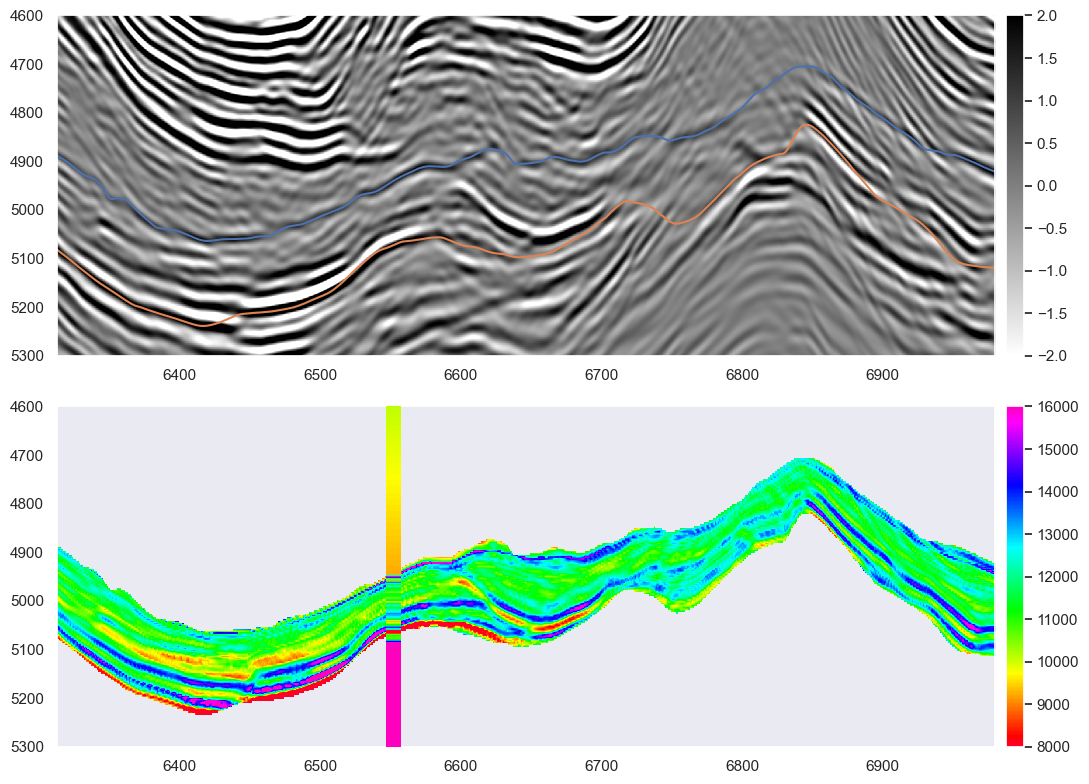

In [92]:
#Plotting Inversion result

fig, ax = plt.subplots(2,1,figsize=(12, 8))
c=ax[0].imshow(data_cube[7857-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-2, vmax=2,
            extent=[xl_start, xl_end, t[-1], t[0]])
plt.colorbar(c, ax=ax[0], pad=0.01)

ax[0].plot(topo.loc[topo.Y==7857].X, topo.loc[topo.Y==7857].Z)
ax[0].plot(base.loc[base.Y==7857].X, base.loc[base.Y==7857].Z)

c=ax[1].imshow(minv_tbt*ip_mask[7857-il_start,:,750:1500].T, aspect='auto', cmap='gist_rainbow', vmin=8000, vmax=16000,alpha=1.0,
            extent=[xl_start, xl_end, 6000, 3000])

#ax[1].plot(topo.loc[topo.Y==7857].X, topo.loc[topo.Y==7857].Z)
#ax[1].plot(base.loc[base.Y==7857].X, base.loc[base.Y==7857].Z)
ax[1].imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=8000, vmax=16000,
             extent=(6552-5, 6552+5, 6000, 3000), zorder=20)
plt.colorbar(c, ax=ax[1], pad=0.01)

for axs in (ax[0], ax[1]):
    axs.set_xlim(xl_start, xl_end)
    axs.set_ylim(5300, 4600)
    axs.grid(False)
    
plt.tight_layout()

(5400.0, 4800.0)

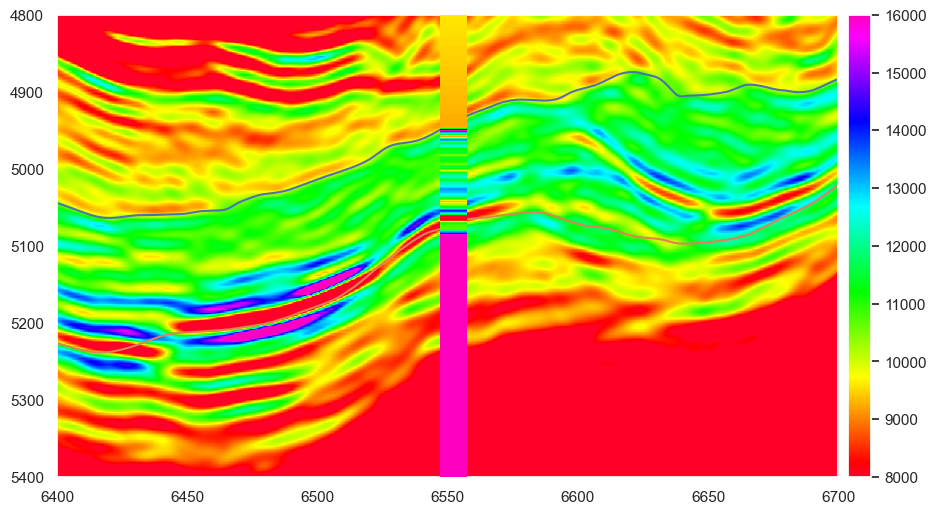

In [93]:
#Plotting Inversion result

fig, ax = plt.subplots(figsize=(12, 6))
c=ax.imshow(minv_tbt_2, aspect='auto', cmap='gist_rainbow', vmin=8000, vmax=16000,
            extent=[xl_start, xl_end, 6000, 3000])
ax.imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=8000, vmax=16000,
             extent=(6552-5, 6552+5, 6000, 3000), zorder=20)
ax.plot(topo.loc[topo.Y==7857].X, topo.loc[topo.Y==7857].Z)
ax.plot(base.loc[base.Y==7857].X, base.loc[base.Y==7857].Z)
plt.colorbar(c, ax=ax, pad=0.01)
ax.set_xlim(6400, 6700)
plt.grid(False)
ax.set_ylim(5400, 4800)

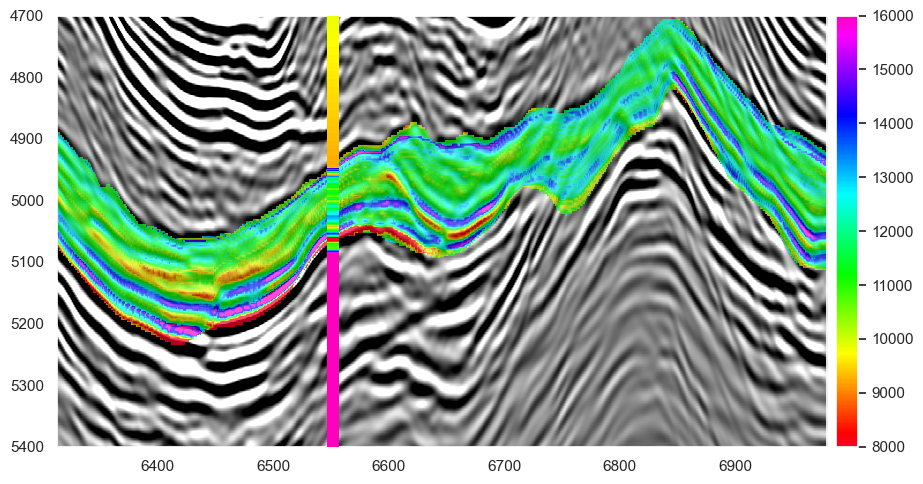

In [94]:
#Plotting seismic and Inversion result in overlay

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

c=ax.imshow(data_cube[7857-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
c=ax.imshow(minv_tbt*ip_mask[7857-il_start,:,750:1500].T , aspect='auto', extent=[xl_start, xl_end, 6000, 3000],
          alpha=0.7, cmap='gist_rainbow', vmin=8000, vmax=16000)
c=ax.imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=8000, vmax=16000,
             extent=(6552-5, 6552+5, 6000, 3000), zorder=20)

plt.colorbar(c, ax=ax, pad=0.01)


ax.set_xlim(xl_start, xl_end)
ax.set_ylim(5400, 4700)
ax.grid(False)

plt.tight_layout()


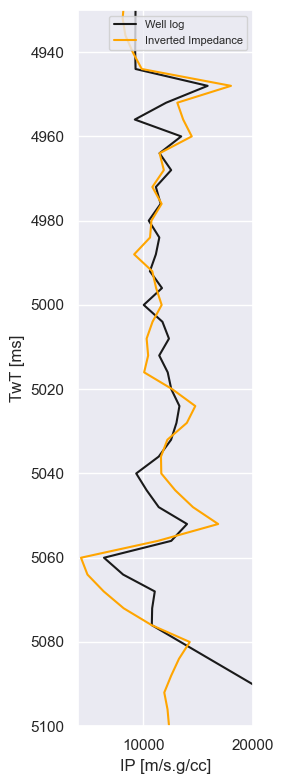

In [95]:
fig, ax = plt.subplots(figsize=(3, 8))

ax.plot(nwell['IP_UPS'], np.arange(3000, 6000, 4), color='k', label='Well log')
ax.plot(minv_tbt[:, 6552-xl_start], np.arange(3000, 6000, 4), color='orange', label='Inverted Impedance')


#ax.axhline(2803.4, color='lime', label='Het Top')
#ax.axhline(2858.244, color='m', label='Sand base')

ax.set_ylabel('TwT [ms]')
ax.set_xlabel('IP [m/s.g/cc]')

ax.set_ylim(5100, 4930)

ax.set_xlim(4000, 20000)

ax.legend(fontsize=8, loc =1)

plt.tight_layout()

In [37]:
# Trace-by-trace in the whole 3D volume

ip_volume = np.full_like(data_cube, np.nan)

for i in range(data_cube.shape[0]):
    amp = data_cube[i, :, 750:1500].T
    # Log of the low frequency model of impedance
    mback = np.log(m0_cube_low[i, :, 750:1500].T)
    # Wavelet operator
    nz, nx = amp.shape
    PPop = pylops.avo.poststack.PoststackLinearModelling(wav_est/2,
                                                         nt0=nz,
                                                         spatdims=nx,
                                                         explicit=True)

    # Trace-by-trace
    minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
        Op=PPop,
        y=amp.ravel() / 10,
        Regs=None,
        epsI=4e-1,
        x0=mback.ravel(),
        **dict(maxiter=1000))
    minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))
    ip_volume[i, :, 750:1500] = minv_tbt.T
    
    print(f'Running IL {i+1}/{data_cube.shape[0]}\r', end="")

In [40]:
# Maps
map_topo = np.full((nil, nxl), np.nan)
map_base = np.full((nil, nxl), np.nan)

for i in range(0, nil):
    for j in range(0, nxl):
        map_topo[i, j] = np.mean(ip_volume[i, j,
                                   int(topo_surface[i, j]//4):int(topo_surface[i, j]//4 + 10)])
        map_base[i, j] = np.mean(ip_volume[i, j,
                                      int(base_surface[i, j]//4 - 10):int(base_surface[i, j]//4)])

In [41]:
import matplotlib.colors as colors

# create a list of hexadecimal color codes
hex_colors = ['#631213', '#A92219', '#E42B19', '#FF2E17', '#FF4F1C', '#FF8427', '#FFB031', 
              '#FFDB3B', '#F1E443', '#B8D544', '#78C647', '#5BBE49', '#3BB851', '#1F8781',
              '#1451AC', '#1F4AA7', '#2148A5', '#30319A']

# create a list of normalized values from 0 to 1
values = np.linspace(0, 1, len(hex_colors))

# create a dictionary with the color values for each segment
colors_dict = {value: color for value, color in zip(values, hex_colors)}

# create a LinearSegmentedColormap using the dictionary of color values
cmap = colors.LinearSegmentedColormap.from_list('my_cmap', list(colors_dict.items()))

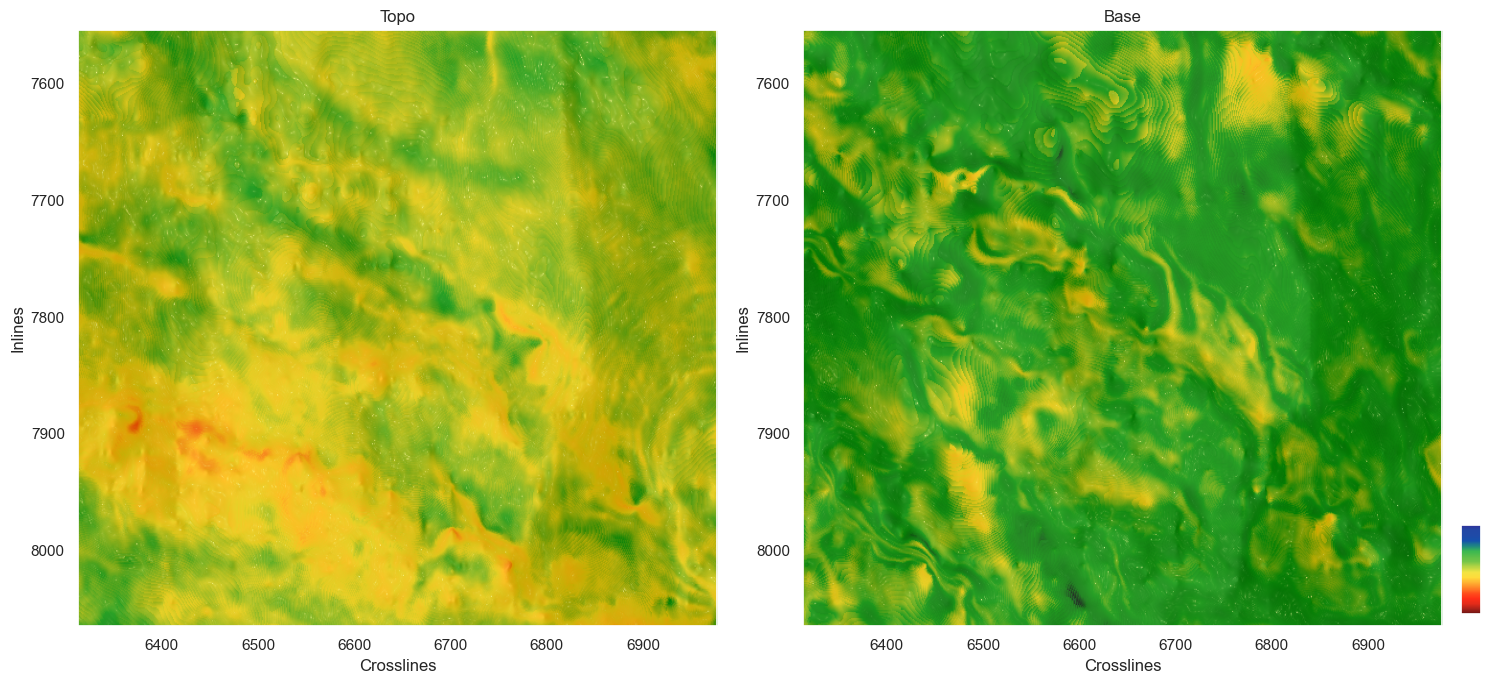

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

im = ax[1].imshow(map_base, cmap=cmap)
im.remove()
axin1 = ax[1].inset_axes([1.03, 0.02, 0.03, 0.15])
axin1.grid(False)
axin1.set(xticks=[],
          yticks=[])
plt.colorbar(im, cax=axin1, ticks=[])

ls = colors.LightSource(azdeg = 90, altdeg = 90)
rgb = ls.shade(map_topo, cmap=cmap, blend_mode='overlay', vmin=6000, vmax=17000,
               vert_exag=1)
ax[0].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start], cmap=cmap)

ls = colors.LightSource(azdeg = 90, altdeg = 45)
rgb = ls.hillshade(topo_surface, vert_exag=1)
c0=ax[0].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start],
                cmap='gray', alpha=0.15)


ls = colors.LightSource(azdeg = 90, altdeg = 90)
rgb = ls.shade(map_base, cmap=cmap, blend_mode='overlay', vmin=5000, vmax=16000,
               vert_exag=1)
ax[1].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start], cmap=cmap)

ls = colors.LightSource(azdeg = 90, altdeg = 45)
rgb = ls.hillshade(base_surface, vert_exag=1)
c0=ax[1].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start],
                cmap='gray', alpha=0.15)

for axs in fig.get_axes():
    axs.grid(False)
    axs.set_xlabel('Crosslines')
    axs.set_ylabel('Inlines')
    '''axs.scatter(5118, 3534, color='k', zorder=20, edgecolor='w')
    axs.scatter(5462, 3100, color='k', zorder=20, edgecolor='w')
    axs.scatter(4722, 3331, color='k', zorder=20, edgecolor='w')
    axs.scatter(4765, 3493, color='k', zorder=20, edgecolor='w')
    axs.scatter(5305, 2996, color='k', zorder=20, edgecolor='w')
    axs.scatter(5370, 3230, color='k', zorder=20, edgecolor='w')
    axs.scatter(5553, 2862, color='k', zorder=20, edgecolor='w')
    axs.scatter(5313, 3157, color='k', zorder=20, edgecolor='w')'''
    #axs.set_xlim(2000, xl_end)
    #axs.set_ylim(2500, 1600)
    
ax[0].set_title('Topo')
ax[1].set_title('Base')

plt.tight_layout()